In [1]:
import pandas as pd
import numpy as np
import seaborn as sb

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from scipy.stats import norm, skew #for some statistics
from scipy import stats #qqplot
import statsmodels.api as sm #for decomposing the trends, seasonality etc.

from statsmodels.tsa.statespace.sarimax import SARIMAX 

In [3]:
data = pd.read_csv("NFLX.csv")
data

,Date,Open,High,Low,Close,Adj Close,Volume
0,2018-02-05,262.000000,267.899994,250.029999,254.259995,254.259995,11896100
1,2018-02-06,247.699997,266.700012,245.000000,265.720001,265.720001,12595800
2,2018-02-07,266.579987,272.450012,264.329987,264.559998,264.559998,8981500
3,2018-02-08,267.079987,267.619995,250.000000,250.100006,250.100006,9306700
4,2018-02-09,253.850006,255.800003,236.110001,249.470001,249.470001,16906900
...,...,...,...,...,...,...,...
1004,2022-01-31,401.970001,427.700012,398.200012,427.140015,427.140015,20047500
1005,2022-02-01,432.959991,458.480011,425.540009,457.130005,457.130005,22542300
1006,2022-02-02,448.250000,451.980011,426.480011,429.480011,429.480011,14346000
1007,2022-02-03,421.440002,429.260010,404.279999,405.600006,405.600006,9905200


In [4]:
data = data.drop(['Open', 'High', 'Low', 'Close', 'Volume'], axis=1)
data

,Date,Adj Close
0,2018-02-05,254.259995
1,2018-02-06,265.720001
2,2018-02-07,264.559998
3,2018-02-08,250.100006
4,2018-02-09,249.470001
...,...,...
1004,2022-01-31,427.140015
1005,2022-02-01,457.130005
1006,2022-02-02,429.480011
1007,2022-02-03,405.600006


In [5]:
print (data.isna().sum())

Date         0
Adj Close    0
dtype: int64


C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


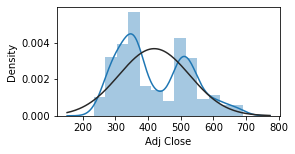

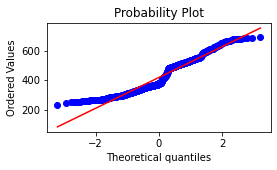

In [7]:
from matplotlib import rcParams
# figure size in inches
rcParams['figure.figsize'] = 4,2

sb.distplot(data['Adj Close'], fit=norm)

#Get the QQ-plot
fig = plt.figure()
res = stats.probplot(data['Adj Close'], plot=plt)
plt.show()

In [9]:
data = data.groupby('Date')['Adj Close'].sum().reset_index()

In [10]:
data.Date=pd.to_datetime(data.Date)
data

,Date,Adj Close
0,2018-02-05,254.259995
1,2018-02-06,265.720001
2,2018-02-07,264.559998
3,2018-02-08,250.100006
4,2018-02-09,249.470001
...,...,...
1004,2022-01-31,427.140015
1005,2022-02-01,457.130005
1006,2022-02-02,429.480011
1007,2022-02-03,405.600006


In [11]:
data.set_index(['Date'],inplace=True)
data.head()

,Adj Close
Date,
2018-02-05,254.259995
2018-02-06,265.720001
2018-02-07,264.559998
2018-02-08,250.100006
2018-02-09,249.470001


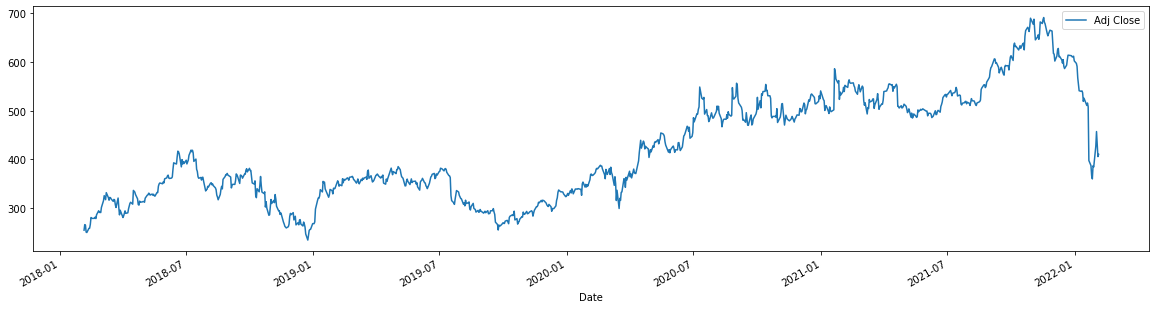

In [12]:
data.plot(figsize=(20,5))
plt.show()

#### Checking for stationarity using Augmented Dickey Fuller Test:

In [13]:
from statsmodels.tsa.stattools import adfuller

def adfuller_test(trends):
    result = adfuller(trends)
    labels = ['ADF Test Statistic','p-value','#Lags Used','#Observation Used']
    for value,label in zip(result,labels):
        print(label  + ': ' + str(value))
    if result[1]<=0.05:
        print('Strong evidence against the null hypothesis, Hence REJECT Ho. and The series is Stationary')
    else:
        print('week evidence against null hypothesis, Hence ACCEPT Ho. that the series is not stationary.')
        
adfuller_test(data['Adj Close'])

ADF Test Statistic: -1.8125906878289952
p-value: 0.37422892568207605
#Lags Used: 6
#Observation Used: 1002
week evidence against null hypothesis, Hence ACCEPT Ho. that the series is not stationary.


#### Differencing the data to make it stationary:

ADF Test Statistic: -14.242275992929116
p-value: 1.5304022754298515e-26
#Lags Used: 5
#Observation Used: 1002
Strong evidence against the null hypothesis, Hence REJECT Ho. and The series is Stationary


<AxesSubplot:xlabel='Date'>

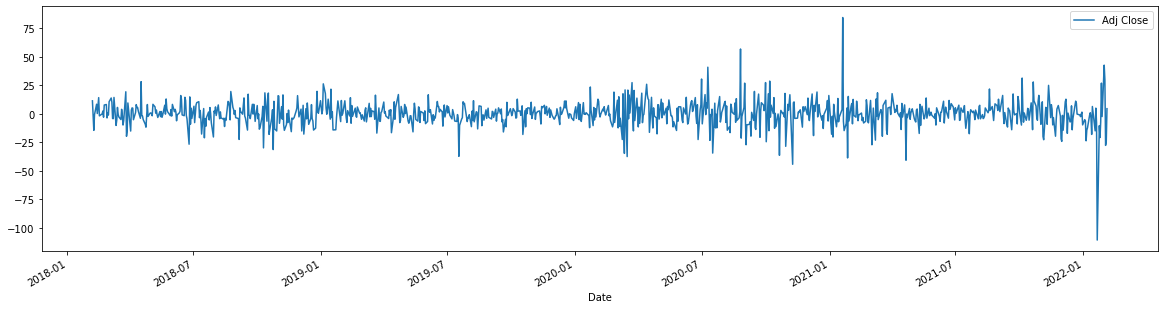

In [14]:
diff1=data-data.shift(1)
diff1=diff1.dropna()
adfuller_test(diff1)
diff1.plot(figsize=(20,5))

In [15]:
#The data is now stationary and the order of differencing is 1

#### Plotting Autocorrelation and Partial Autocorreltion functions to find the number of lags:

In [18]:
import statsmodels.graphics.tsaplots as sgt

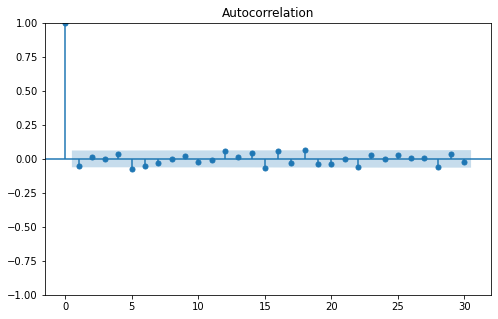

In [19]:
fig, ax = plt.subplots(figsize=(8, 5))
sgt.plot_acf(diff1['Adj Close'], ax=ax, lags=30)
plt.show()

##### Thus, number of lags for MA -> 7

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


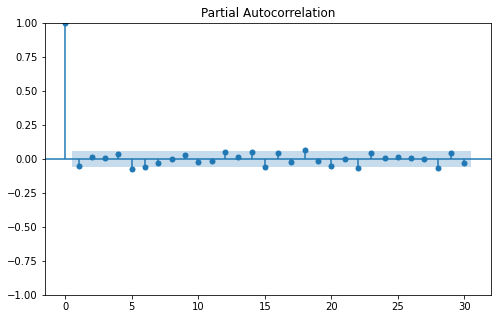

In [20]:
fig, ax = plt.subplots(figsize=(8, 5))
sgt.plot_pacf(diff1['Adj Close'], ax=ax, lags=30)
plt.show()

##### Number of lags for AR -> 7

#### Finding the most optimal values of p and q:

In [22]:
from statsmodels.tsa.arima.model import ARIMA
import warnings
warnings.filterwarnings("ignore")
for i in range(1,7):
    for j in range(1,7):
        model=ARIMA(data['Adj Close'],order=(i,0,j))
        result=model.fit()
        print(f"AIC :{result.aic}, Order Of AR: {i}, Order of MA:{j} ")

AIC :7719.25272539023, Order Of AR: 1, Order of MA:1 
AIC :7720.890983918487, Order Of AR: 1, Order of MA:2 
AIC :7722.748629703621, Order Of AR: 1, Order of MA:3 
AIC :7723.685761831282, Order Of AR: 1, Order of MA:4 
AIC :7718.415482134175, Order Of AR: 1, Order of MA:5 
AIC :7718.172317923943, Order Of AR: 1, Order of MA:6 
AIC :7719.876850432761, Order Of AR: 2, Order of MA:1 
AIC :7723.251351790019, Order Of AR: 2, Order of MA:2 
AIC :7724.674017314607, Order Of AR: 2, Order of MA:3 
AIC :7723.762865519189, Order Of AR: 2, Order of MA:4 
AIC :7718.287566398078, Order Of AR: 2, Order of MA:5 
AIC :7720.06948758604, Order Of AR: 2, Order of MA:6 
AIC :7721.431356151079, Order Of AR: 3, Order of MA:1 
AIC :7714.6856757721835, Order Of AR: 3, Order of MA:2 
AIC :7725.176499993192, Order Of AR: 3, Order of MA:3 
AIC :7720.5917592959495, Order Of AR: 3, Order of MA:4 
AIC :7719.970658335595, Order Of AR: 3, Order of MA:5 
AIC :7722.088940690566, Order Of AR: 3, Order of MA:6 
AIC :7723.

#### Building ARIMA Model:

In [23]:
model=ARIMA(data['Adj Close'],order=(6,1,6))
result=model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:              Adj Close   No. Observations:                 1009
Model:                 ARIMA(6, 1, 6)   Log Likelihood               -3838.362
Date:                Sun, 25 Aug 2024   AIC                           7702.725
Time:                        16:48:00   BIC                           7766.629
Sample:                             0   HQIC                          7727.003
                               - 1009                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2228      0.065      3.452      0.001       0.096       0.349
ar.L2          0.6266      0.062     10.139      0.000       0.505       0.748
ar.L3         -1.1330      0.068    -16.545      0.000      -1.267      -0.999
ar.L4          0.5394      0.062      8.678      0.000       0.418       0.661
ar.L5          0.2457      0.056      4.355      0.000       0.135       0.356
ar.L6         -0.8752      0.065    -13.549      0.000      -1.002      -0.749
ma.L1         -0.2627      0.074     -3.545      0.000      -0.408      -0.117
ma.L2         -0.5880      0.068     -8.676      0.000      -0.721      -0.455
ma.L3          1.1598      0.070     16.466      0.000       1.022       1.298
ma.L4         -0.5770      0.065     -8.898      0.000      -0.704      -0.450
ma.L5         -0.2655      0.065     -4.065      0.000      -0.394      -0.138
ma.L6          0.8400      0.073     11.539      0.000       0.697       0.983
sigma2       120.4573      2.384     50.532      0.000     115.785     125.129
===================================================================================
Ljung-Box (L1) (Q):                   0.10   Jarque-Bera (JB):              9328.17
Prob(Q):                              0.76   Prob(JB):                         0.00
Heteroskedasticity (H):               2.16   Skew:                            -0.72
Prob(H) (two-sided):                  0.00   Kurtosis:                        17.83
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

#### Plotting the ARIMA prediction result:

<AxesSubplot:xlabel='Date'>

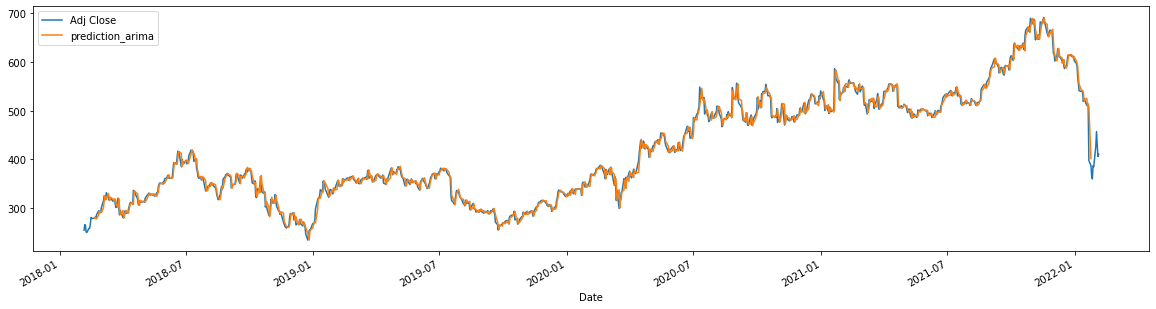

In [24]:
data['prediction_arima']=result.predict(start=10,end=999)
data[["Adj Close","prediction_arima"]].plot(figsize=(20,5))

#### Forecasting Stock Price for the next 30 days:

In [25]:
fc = result.forecast(30, alpha=0.05)
for i in fc:
    print(round(i,0))

409.0
400.0
393.0
392.0
396.0
398.0
398.0
400.0
406.0
411.0
412.0
407.0
404.0
403.0
402.0
398.0
394.0
395.0
399.0
403.0
404.0
405.0
407.0
409.0
408.0
404.0
400.0
399.0
399.0
399.0


#### Thus, it is noted that the stock prices of the next 3 days has very small variability ranging between 405 and 411.

In [26]:
fc = [408.0, 408.0, 407.0, 405.0, 411.0, 409.0, 410.0, 407.0, 407.0, 410.0, 409.0, 411.0, 407.0, 408.0, 409.0, 409.0, 410.0, 407.0, 409.0, 409.0, 410.0, 410.0, 408.0, 409.0, 408.0, 410.0, 409.0, 408.0, 409.0, 409.0]

# Create a date range from '2022-02-05' to '2022-03-06'
start_date = '2022-02-05'
end_date = '2022-03-06'
date_range = pd.date_range(start=start_date, end=end_date)


fc_with_dates = pd.Series(fc, index=date_range)
print(fc_with_dates)

2022-02-05    408.0
2022-02-06    408.0
2022-02-07    407.0
2022-02-08    405.0
2022-02-09    411.0
2022-02-10    409.0
2022-02-11    410.0
2022-02-12    407.0
2022-02-13    407.0
2022-02-14    410.0
2022-02-15    409.0
2022-02-16    411.0
2022-02-17    407.0
2022-02-18    408.0
2022-02-19    409.0
2022-02-20    409.0
2022-02-21    410.0
2022-02-22    407.0
2022-02-23    409.0
2022-02-24    409.0
2022-02-25    410.0
2022-02-26    410.0
2022-02-27    408.0
2022-02-28    409.0
2022-03-01    408.0
2022-03-02    410.0
2022-03-03    409.0
2022-03-04    408.0
2022-03-05    409.0
2022-03-06    409.0
Freq: D, dtype: float64


#### Plotting the forecasted stock prices:

<AxesSubplot:>

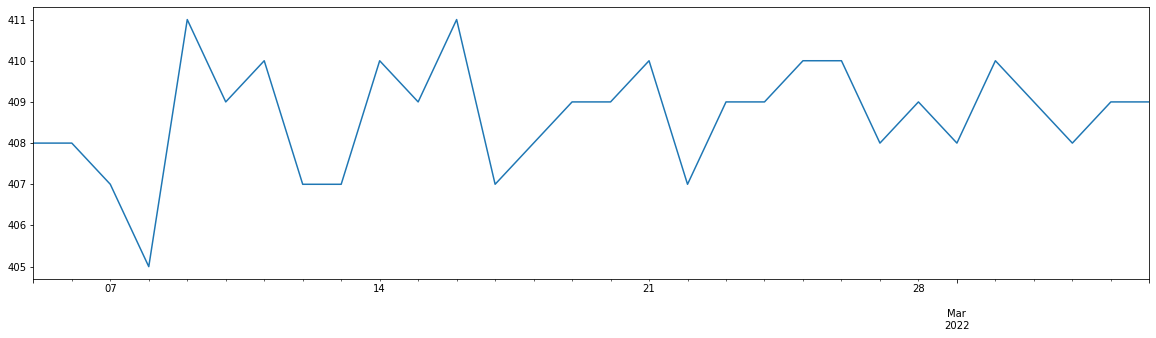

In [27]:
fc_with_dates.plot(figsize=(20,5))

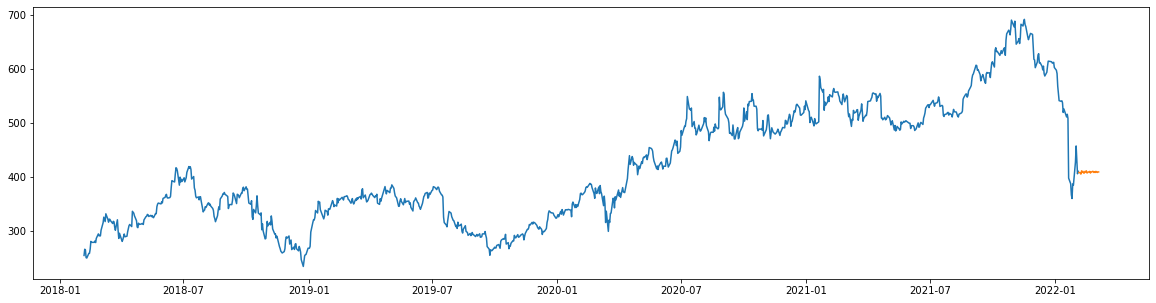

In [29]:
plt.figure(figsize=(20,5))
plt.plot(data["Adj Close"])
plt.plot(fc_with_dates)